## 1 - Importação de bibliotecas

In [1]:
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import option_context
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
from matplotlib import pyplot
import math
import numpy as np
%matplotlib inline

## 2 - Funções de apoio

### 2.1 - Exibe de dados do dataset

In [2]:
def exibe_dataset(dados, linhas): 
    with option_context('display.max_rows',linhas*2):
        display(dados)

### 2.2 - Prepara dataset para as operações de treino e teste 

#### Cria registro com o conjunto de dados de entrada e dos dados da previsão

In [3]:
def converte_serie(dados, num_in, num_out):
    colunas, nomes = list(), list()

    num_vars = 1 if type(dados) is list else dados.shape[1]
    df = DataFrame(dados)

    for i in range(num_in, 0, -1):
        colunas.append(df.shift(i))
        nomes += [('x%d(t-%d)' % (j+1, i)) for j in range(num_vars)]

    for i in range(0, num_out):
        colunas.append(df.shift(-i))
        if i == 0:
            nomes += [('x%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            nomes += [('x%d(t+%d)' % (j+1, i)) for j in range(num_vars)]

    serie = concat(colunas, axis=1)
    serie.columns = nomes
    serie.dropna(inplace=True)
    
    return serie

### 2.3 - Cria datasets de treino e teste

In [4]:
def cria_dataset_treino_teste(ds_nova_escala, num_time_frames):
    num_time_frames_aux = num_time_frames
    num_features_aux = ds_nova_escala.shape[1]
    num_obs_aux = num_time_frames_aux * num_features_aux

    ds_convertido = converte_serie(ds_nova_escala, num_time_frames_aux, 1)

    m = []
    for i in range(num_features_aux+1,num_features_aux*2):
        m.append(i)

    ds_convertido.drop(ds_convertido.columns[m], axis=1, inplace=True)

    ds_valor = ds_convertido.values

    tam = int(len(ds_valor) * 0.66)

    ds_treino = ds_valor[:tam, :]
    ds_teste = ds_valor[tam:, :]
    ds_treino_tam = len(ds_treino)
    ds_teste_tam = len(ds_teste)

    X_treino_aux, y_treino_aux = ds_treino[:, :(-1 if num_time_frames_aux == 1 else num_obs_aux)], ds_treino[:, -num_features_aux]
    X_teste_aux, y_teste_aux = ds_teste[:, :(-1 if num_time_frames_aux == 1 else num_obs_aux)], ds_teste[:, -num_features_aux]

    X_treino_aux = X_treino_aux.reshape((X_treino_aux.shape[0], num_time_frames_aux, (X_treino_aux.shape[1] if num_time_frames_aux == 1 else num_features_aux)))
    X_teste_aux = X_teste_aux.reshape((X_teste_aux.shape[0], num_time_frames_aux, (X_teste_aux.shape[1] if num_time_frames_aux == 1 else num_features_aux)))

    return X_treino_aux, y_treino_aux, X_teste_aux, y_teste_aux, num_time_frames_aux, num_features_aux, num_obs_aux

### 2.4 - Exibe resultados de execução do modelo de rede neural 

In [5]:
def exibe_resultados(historico, teste_inv, previsao_inv, label_loss, label_previsao, label_mse):
    pyplot.figure(figsize=(15, 4), dpi=100)

    pyplot.subplot(1, 2, 1)
    pyplot.plot(historico.history['loss'], label='Treino', color='tab:green')
    pyplot.plot(historico.history['val_loss'], label='Teste', color='tab:pink')
    pyplot.title(label_loss)
    pyplot.ylabel('Loss')
    pyplot.xlabel('Épocas')
    pyplot.legend()

    pyplot.subplot(1, 2, 2)
    pyplot.plot(teste_inv, label='Fechamento', color='b')
    pyplot.plot(previsao_inv, label='Previsão', color='tab:orange')
    pyplot.title(label_previsao)
    pyplot.ylabel('R$')
    pyplot.legend()

    pyplot.show()

    print(label_mse)
    
    mse = mean_squared_error(teste_inv, previsao_inv)
    print('- MSE: %.3f' % mse)
    
    rmse = math.sqrt(mean_squared_error(teste_inv, previsao_inv))
    print('- RMSE: %.3f' % rmse)
    
    mape = np.mean(np.abs((teste_inv - previsao_inv) / teste_inv)) * 100
    print('- MAPE: %.3f' % mape, '%')

### 2.5 - Processa modelo de rede neural

#### O projeto fará a previsão do preço de fechamento usando os modelos RNN, LSTM e GRU. Os modelos usaram duas camadas de neurônios com uma camada de saída. O número de épocas de treinamento será 50, utilizando a função loss 'mae', e o otimizador 'adam'.

In [6]:
def processa_modelo(tipo, X_treino, y_treino, X_teste, y_teste, num_time_frames, num_obs, num_features):
    modelo = Sequential()

    if tipo == 'LSTM':
        modelo.add(LSTM(units=50, input_shape=(X_treino.shape[1], X_treino.shape[2]), return_sequences=True))
        modelo.add(LSTM(units=50))
        modelo.add(Dense(units = 1))
        modelo.compile(loss='mae', optimizer='adam')
        historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=64, validation_data=(X_teste, y_teste), verbose=0, shuffle=False)
    elif tipo == 'RNN':
        modelo.add(SimpleRNN(50, input_shape=(X_treino.shape[1], X_treino.shape[2]), return_sequences=True))
        modelo.add(SimpleRNN(50))
        modelo.add(Dense(1))
        modelo.compile(loss='mae', optimizer='adam')
        historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=72, validation_data=(X_teste, y_teste), verbose=0)
    elif tipo == 'GRU':
        modelo.add(GRU(units=50, input_shape=(X_treino.shape[1], X_treino.shape[2]), return_sequences=True))
        modelo.add(GRU(units=50))
        modelo.add(Dense(units=1))
        modelo.compile(loss='mae', optimizer='adam')
        historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=72, validation_data=(X_teste, y_teste), verbose=0)
      
    previsao = modelo.predict(X_teste)

    X_teste_rsp = X_teste.reshape((X_teste.shape[0], (X_teste.shape[2] if num_time_frames == 1 else num_obs)))

    previsao_inv = concatenate((previsao, X_teste_rsp[:, (1 if num_time_frames == 1 else (-1*num_features+1)):]), axis=1)
    previsao_inv = sc.inverse_transform(previsao_inv)
    previsao_inv = previsao_inv[:,0]

    y_teste_rsp = y_teste.reshape((len(y_teste), 1))

    teste_inv = concatenate((y_teste_rsp, X_teste_rsp[:, (1 if num_time_frames == 1 else (-1*num_features+1)):]), axis=1)
    teste_inv = sc.inverse_transform(teste_inv)
    teste_inv = teste_inv[:,0]
    
    return historico, teste_inv, previsao_inv

### 2.6 - Adiciona os indicadores técnicos ao dataset de trabalho

#### Os indicadores técnicos utilizados são:
#### - Média Aritmética - Mede o valor médio em um período. Vamos usar os períodos de 7 (ma7) e 21 (ma21) dias.
#### - Média Móvel Exponencial (ema) - Atribui maior peso aos dados mais recentes.
#### - Bandas de Bolling - As bandas de Bolling criam uma área formada pela banda superior (uppb) e inferior (lowb). As bandas indicam se o preço vai ter uma valorização ou uma queda baseado no histórico da ação.

In [7]:
def adiciona_indicadores_tecnicos(dados):
    dados['ma7'] = dados['Adj Close'].rolling(window=7).mean()
    dados['ma21'] = dados['Adj Close'].rolling(window=21).mean()
    dados['ema'] = dados['Adj Close'].ewm(com=0.5).mean()
    dados['sd20'] = dados['Adj Close'].rolling(window=20).std()
    dados['uppb'] = dados['ma21'] + (dados['sd20']*2)
    dados['lowb'] = dados['ma21'] - (dados['sd20']*2)
    
    return dados

### 2.7 - Exibe gráfico do preço de fechamento do dataset de trabalho

In [8]:
def exibe_grafico_com_preco_fechamento(dados, titulo):
    pyplot.figure(figsize=(6, 3), dpi=100)
    pyplot.plot(dados.iloc[-150:,0],label='Preço Fechamento', color='b')
    pyplot.title(titulo)
    pyplot.ylabel('R$')
    pyplot.ylabel('Período')
    pyplot.xticks([dados.index[-150:].min(), dados.index[-150:].max()])
    pyplot.legend()

### 2.8 - Exibe gráfico do preço de fechamento junto com os indicadores técnicos aplicados ao dataset de trabalho

In [9]:
def exibe_grafico_com_indicadores(dados, titulo):
    pyplot.figure(figsize=(10, 5), dpi=100)
    pyplot.plot(dados.iloc[-150:,0],label='Preço Fechamento', color='b')
    pyplot.plot(dados.iloc[-150:,1],label='MA 5', color='g', linestyle='--')
    pyplot.plot(dados.iloc[-150:,2],label='MA 15', color='r', linestyle='--')
    pyplot.plot(dados.iloc[-150:,3],label='EMA', color='tab:pink', linestyle='--')
    pyplot.plot(dados.iloc[-150:,5],label='Upper Band', color='darkgoldenrod', linestyle='--')
    pyplot.plot(dados.iloc[-150:,6],label='Lower Band', color='gold', linestyle='--')
    pyplot.title(titulo)
    pyplot.ylabel('R$')
    pyplot.ylabel('Período')
    pyplot.xticks([dados.index[-150:].min(), dados.index[-150:].max()])
    pyplot.legend()

### 2.9 - Executa o teste de determinado modelo para um número de repetições

In [10]:
def processa_experimento(modelo, repeticoes, X_treino, y_treino, X_teste, y_teste, num_time_frames, num_obs, num_features):
    resultados = DataFrame()

    aval_mse = list()
    aval_rmse = list()
    aval_mape = list()

    for r in range(repeticoes):
        historico, teste, previsao = processa_modelo(modelo, X_treino, y_treino, X_teste, y_teste, num_time_frames, num_obs, num_features)
        mse = mean_squared_error(teste, previsao)
        rmse = math.sqrt(mean_squared_error(teste, previsao))
        mape = np.mean(np.abs((teste - previsao) / teste)) * 100

        aval_mse.append(mse)
        aval_rmse.append(rmse)
        aval_mape.append(mape)
        
    resultados[modelo + ' - MSE'] = aval_mse
    resultados[modelo + ' - RMSE'] = aval_rmse
    resultados[modelo + ' - MAPE'] = aval_mape
    
    return resultados

## 3 - Define valor máximo e mínino da escala de normalização

In [11]:
sc = MinMaxScaler(feature_range=(0,1))

## 4 - Utilizando o preço de fechamento para a previsão

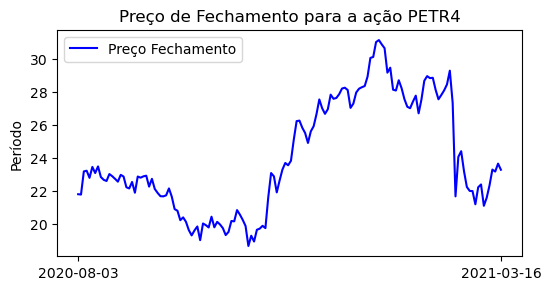

In [12]:
ds_petr4 = read_csv('PETR4.SA.csv', usecols=['Date','Adj Close'], header=0, index_col='Date')
ds_petr4 = ds_petr4.dropna()

exibe_grafico_com_preco_fechamento(ds_petr4, 'Preço de Fechamento para a ação PETR4')

### 4.1 - Criação dos datasets de treino e teste

In [13]:
ds_petr4 = ds_petr4.astype('float32')

ds_petr4_sc = sc.fit_transform(ds_petr4)

num_time_frames_petr4 = 5

X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
    num_time_frames_petr4, num_features_petr4, num_obs_petr4 = \
    cria_dataset_treino_teste(ds_petr4_sc, num_time_frames_petr4)

### 4.2 - Previsão usando o modelo LSTM

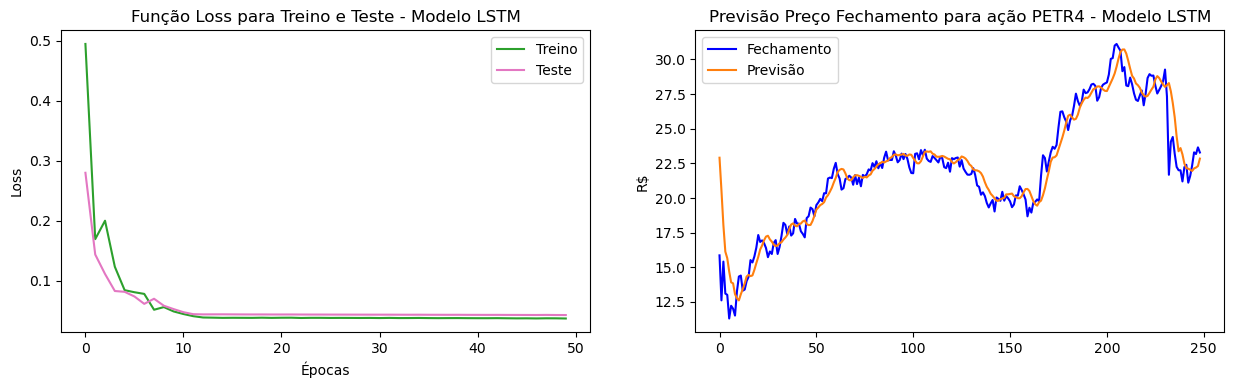

In [14]:
historico_lstm, teste_lstm_inv, previsao_lstm_inv = \
    processa_modelo('LSTM', X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                    num_time_frames_petr4, num_obs_petr4, num_features_petr4)

exibe_resultados(historico_lstm, \
                 teste_lstm_inv, \
                 previsao_lstm_inv, \
                 'Função Loss para Treino e Teste - Modelo LSTM', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo LSTM', \
                 'Modelo LSTM - Métricas de avaliação')

### 4.3 - Previsão usando o modelo RNN

Modelo LSTM - Métricas de avaliação
- MSE: 1.634
- RMSE: 1.278
- MAPE: 4.230 %


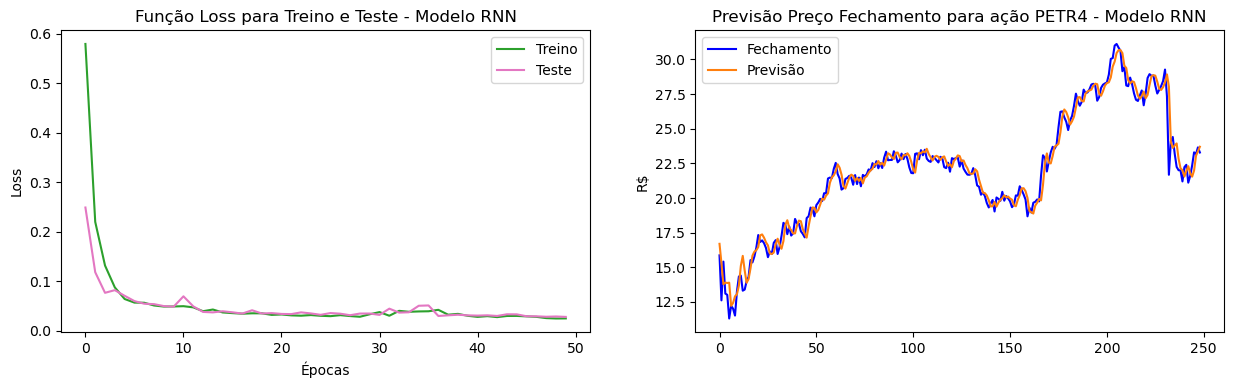

Modelo RNN - Métricas de avaliação
- MSE: 0.648
- RMSE: 0.805
- MAPE: 2.725 %


In [15]:
historico_rnn, teste_rnn_inv, previsao_rnn_inv = \
    processa_modelo('RNN', X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                    num_time_frames_petr4, num_obs_petr4, num_features_petr4)

exibe_resultados(historico_rnn, \
                 teste_rnn_inv, \
                 previsao_rnn_inv, \
                 'Função Loss para Treino e Teste - Modelo RNN', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo RNN', \
                 'Modelo RNN - Métricas de avaliação')

### 4.4 - Previsão usando o modelo GRU

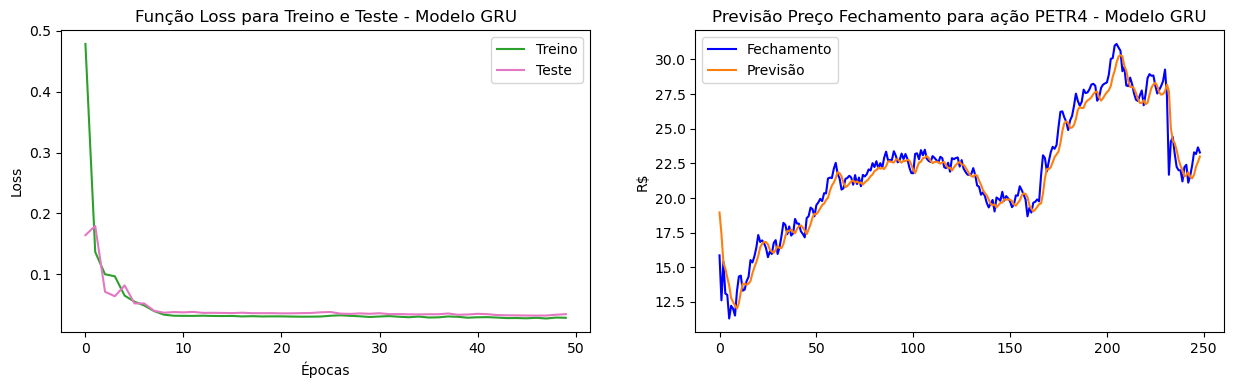

Modelo GRU - Métricas de avaliação
- MSE: 0.907
- RMSE: 0.952
- MAPE: 3.315 %


In [16]:
historico_gru, teste_gru_inv, previsao_gru_inv = \
    processa_modelo('GRU', X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                    num_time_frames_petr4, num_obs_petr4, num_features_petr4)

exibe_resultados(historico_gru, \
                 teste_gru_inv, \
                 previsao_gru_inv, \
                 'Função Loss para Treino e Teste - Modelo GRU', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo GRU', \
                 'Modelo GRU - Métricas de avaliação')

### 4.5 - Execução dos testes

In [17]:
repeticoes = 50

resultados_lstm_petr4 = DataFrame()
resultados_rnn_petr4 = DataFrame()
resultados_gru_petr4 = DataFrame()

resultados_lstm_petr4 = processa_experimento('LSTM', repeticoes, \
                                      X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                                      num_time_frames_petr4, num_obs_petr4, num_features_petr4)

resultados_rnn_petr4 = processa_experimento('RNN', repeticoes, \
                                      X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                                      num_time_frames_petr4, num_obs_petr4, num_features_petr4)

resultados_gru_petr4 = processa_experimento('GRU', repeticoes, \
                                      X_treino_petr4, y_treino_petr4, X_teste_petr4, y_teste_petr4, \
                                      num_time_frames_petr4, num_obs_petr4, num_features_petr4)

## 5 - Incluindo indicadores técnicos para fazer a previsão

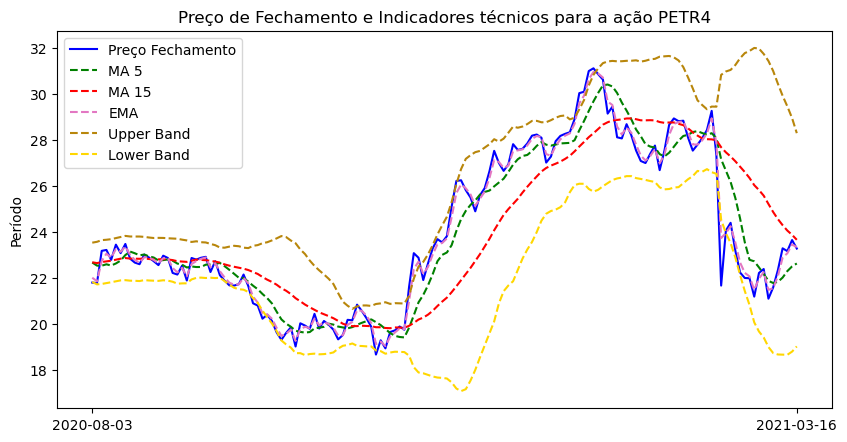

In [18]:
ds_petr4_i = read_csv('PETR4.SA.csv', usecols=['Date','Adj Close'], header=0, index_col='Date')
ds_petr4_i = ds_petr4_i.dropna()

ds_petr4_i = adiciona_indicadores_tecnicos(ds_petr4_i)
ds_petr4_i = ds_petr4_i.dropna()

exibe_grafico_com_indicadores(ds_petr4_i, 'Preço de Fechamento e Indicadores técnicos para a ação PETR4')

### 5.1 - Criação dos datasets de treino e teste

In [19]:
ds_petr4_i = ds_petr4_i.astype('float32')

ds_petr4_i_sc = sc.fit_transform(ds_petr4_i)

num_time_frames_petr4_i = 5

X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
    num_time_frames_petr4_i, num_features_petr4_i, num_obs_petr4_i = \
    cria_dataset_treino_teste(ds_petr4_i_sc, num_time_frames_petr4_i)

### 5.2 - Previsão usando o modelo LSTM

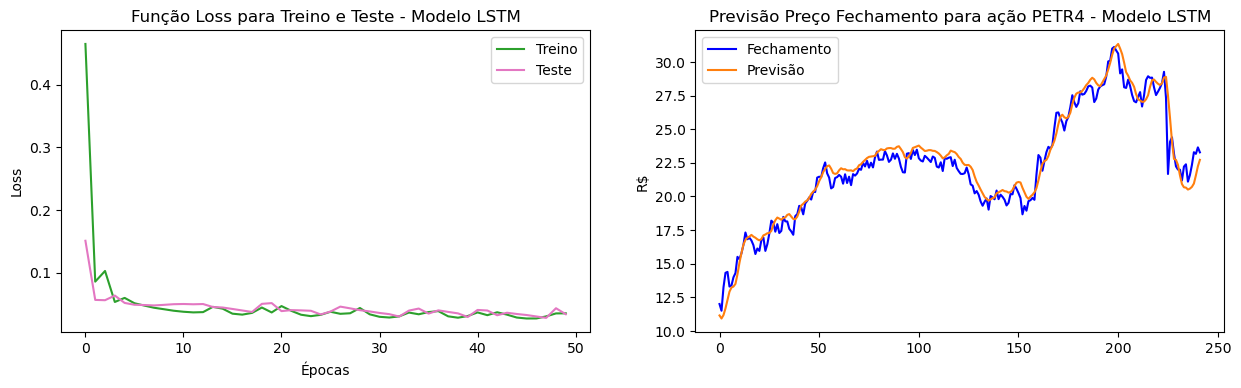

Modelo LSTM - Métricas de avaliação
- MSE: 0.796
- RMSE: 0.892
- MAPE: 3.148 %


In [20]:
historico_lstm_i, teste_lstm_inv_i, previsao_lstm_inv_i = \
    processa_modelo('LSTM', X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                    num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

exibe_resultados(historico_lstm_i, \
                 teste_lstm_inv_i, \
                 previsao_lstm_inv_i, \
                 'Função Loss para Treino e Teste - Modelo LSTM', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo LSTM', \
                 'Modelo LSTM - Métricas de avaliação')

### 5.3 - Previsão usando o modelo RNN

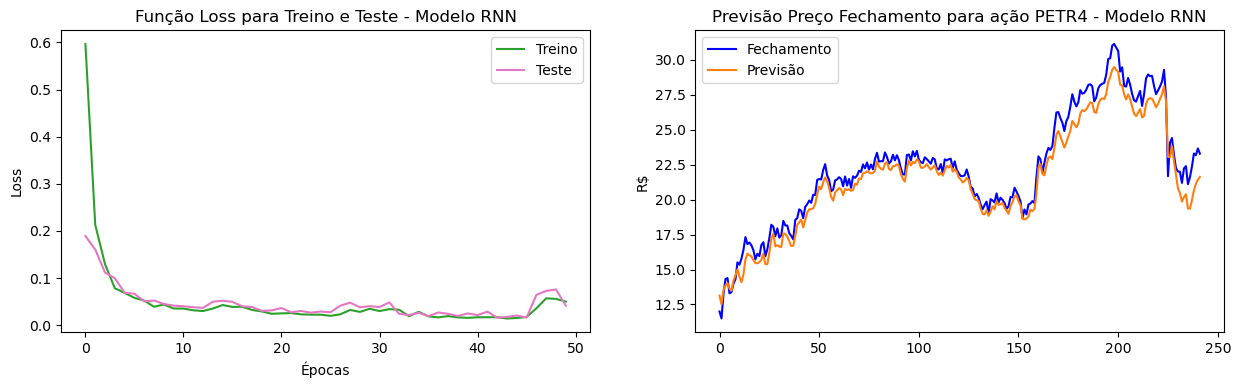

Modelo RNN - Métricas de avaliação
- MSE: 0.911
- RMSE: 0.955
- MAPE: 3.632 %


In [21]:
historico_rnn_i, teste_rnn_inv_i, previsao_rnn_inv_i = \
    processa_modelo('RNN', X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                    num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

exibe_resultados(historico_rnn_i, \
                 teste_rnn_inv_i, \
                 previsao_rnn_inv_i, \
                 'Função Loss para Treino e Teste - Modelo RNN', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo RNN', \
                 'Modelo RNN - Métricas de avaliação')

### 5.4 - Previsão usando o modelo GRU

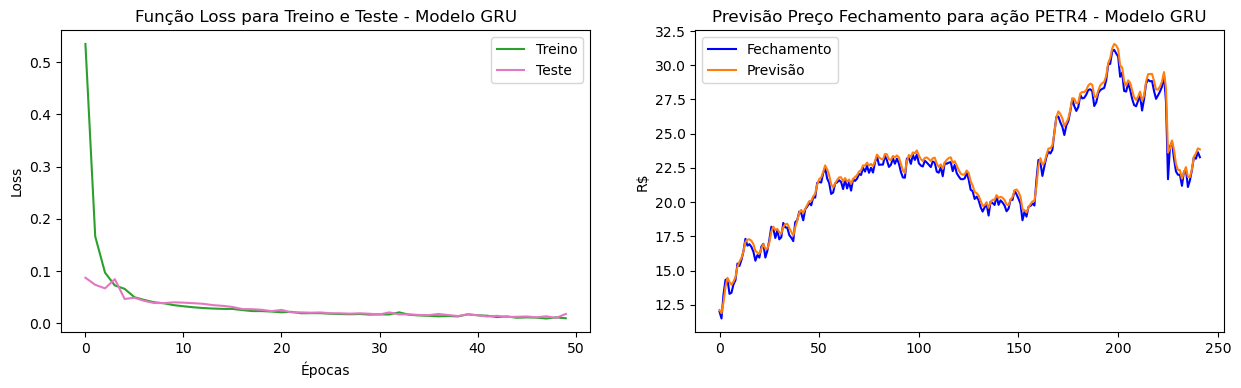

Modelo GRU - Métricas de avaliação
- MSE: 0.174
- RMSE: 0.418
- MAPE: 1.639 %


In [22]:
historico_gru_i, teste_gru_inv_i, previsao_gru_inv_i = \
    processa_modelo('GRU', X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                    num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

exibe_resultados(historico_gru_i, \
                 teste_gru_inv_i, \
                 previsao_gru_inv_i, \
                 'Função Loss para Treino e Teste - Modelo GRU', \
                 'Previsão Preço Fechamento para ação PETR4 - Modelo GRU', \
                 'Modelo GRU - Métricas de avaliação')

### 5.5 - Execução dos testes

In [23]:
repeticoes = 50

resultados_lstm_petr4_i = DataFrame()
resultados_rnn_petr4_i = DataFrame()
resultados_gru_petr4_i = DataFrame()

resultados_lstm_petr4_i = processa_experimento('LSTM', repeticoes, \
                                      X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                                      num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

resultados_rnn_petr4_i = processa_experimento('RNN', repeticoes, \
                                      X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                                      num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)

resultados_gru_petr4_i = processa_experimento('GRU', repeticoes, \
                                      X_treino_petr4_i, y_treino_petr4_i, X_teste_petr4_i, y_teste_petr4_i, \
                                      num_time_frames_petr4_i, num_obs_petr4_i, num_features_petr4_i)


## 6 - Resultados

### 6.1 - Utilizando apenas o preço de fechamento na previsão

In [24]:
print(resultados_lstm_petr4.describe())
print('----------')
print(resultados_rnn_petr4.describe())
print('----------')
print(resultados_gru_petr4.describe())

       LSTM - MSE  LSTM - RMSE  LSTM - MAPE
count   50.000000    50.000000    50.000000
mean     1.642361     1.281464     4.238219
std      0.037566     0.014658     0.041338
min      1.561884     1.249753     4.160854
25%      1.614653     1.270690     4.207794
50%      1.643718     1.282075     4.243656
75%      1.667281     1.291232     4.260082
max      1.739803     1.319016     4.363715
----------
       RNN - MSE  RNN - RMSE  RNN - MAPE
count  50.000000   50.000000   50.000000
mean    0.678521    0.822233    2.840537
std     0.088274    0.050037    0.210530
min     0.601738    0.775718    2.651714
25%     0.622480    0.788973    2.696136
50%     0.647653    0.804769    2.750828
75%     0.717574    0.847097    2.938588
max     1.119809    1.058210    3.804101
----------
       GRU - MSE  GRU - RMSE  GRU - MAPE
count  50.000000   50.000000   50.000000
mean    0.891780    0.944006    3.222588
std     0.048899    0.025398    0.089921
min     0.809507    0.899726    3.060568
25%     

### 6.2 - Utilizando o preço de fechamento em conjunto com os indicadores técnicos na previsão

In [25]:
print(resultados_lstm_petr4_i.describe())
print('----------')
print(resultados_rnn_petr4_i.describe())
print('----------')
print(resultados_gru_petr4_i.describe())

       LSTM - MSE  LSTM - RMSE  LSTM - MAPE
count   50.000000    50.000000    50.000000
mean     0.860848     0.923283     3.156328
std      0.172521     0.092564     0.424457
min      0.553750     0.744144     2.449079
25%      0.718762     0.847776     2.796698
50%      0.853867     0.924046     3.111304
75%      0.966645     0.983174     3.428891
max      1.233162     1.110478     4.126646
----------
       RNN - MSE  RNN - RMSE  RNN - MAPE
count  50.000000   50.000000   50.000000
mean    0.457500    0.621178    2.489184
std     0.459158    0.270370    1.316405
min     0.111372    0.333724    0.998788
25%     0.186530    0.431886    1.556757
50%     0.319920    0.565601    2.215430
75%     0.542782    0.736726    3.194381
max     2.234131    1.494701    6.472777
----------
       GRU - MSE  GRU - RMSE  GRU - MAPE
count  50.000000   50.000000   50.000000
mean    0.159985    0.389703    1.382956
std     0.087129    0.091007    0.356413
min     0.074490    0.272928    0.963720
25%     

#### Avaliando os resultados, pode ser verificado que no geral o experimento que utilizou os indicadores na previsão teve um melhor desempenho. No caso do experimento que utilizou apenas o preço de fechamento na previsão, tivemos o melhor desempenho do modelo RNN, seguido por GRU e LSTM. Ao usar os indicadores técnicos tivemos o melhor do GRU, seguido por RNN e LSTM. Para o experimento que utilizou apenas o preço de fechamento para a previsão, o RNN se mostrou a melhor opção. Esse experimento é mais simples e aproveita bem as vantagens do RNN, tais como treinamento mais rápido e menor complexidade computacional. No caso do modelo mais complexo que utilizou o preço de fachamento junto com os indicadores técnicos, o GRU teve um resultado melhor que o LSTM. Essa superioridade pode ser devido a maior adequação do GRU ao processamento de datases pequenos, que foi o caso do presente trabalho.